In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Lambda, Flatten, Conv2D, Reshape
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model

from cvxpy import partial_trace
import ot  
import ot.plot
%matplotlib inline

In C:\Users\manyasha_n_m\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\manyasha_n_m\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\manyasha_n_m\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\manyasha_n_m\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\manyasha_n_m\Anaconda3\lib\site-packages\matplotlib\

In [2]:
%matplotlib widget


In [3]:
G = np.array([.01,.01,.04])
P = np.array([0.1,0.2,9])
np.sum(G*(np.log(G)-np.log(P)-1)) +np.sum(P)

8.970372810246344

In [4]:
x = np.linspace(0,10, 101)
X, Y = np.meshgrid(x,x)
F = -2*X*Y+X+Y

ax = plt.figure().add_subplot(projection='3d')
ax.plot_surface(X, Y, F, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [2]:
from mitdeeplearning import util
import os
import time
import functools
from IPython import display as ipythondisplay
from IPython.display import clear_output
from tqdm import tqdm

In [3]:
tf.keras.backend.set_floatx('float64')

In [4]:
A = tf.constant(np.array([[1, 0],
                          [0, 4]])/5, dtype='double')
B = tf.constant(np.array([[2, 0], 
                          [0, 2]])/4, dtype='double')

In [5]:
# test cost functions
Cost = np.eye(4, dtype='double')

In [6]:
@tf.function
def kron_op2D(A, B):
    shape_A = (A.shape + (1,1,))
    shape_B = ((1,1,) + B.shape)
    C = tf.reshape(A, shape_A) * tf.reshape(B, shape_B)
    C01 = [tf.concat([C[i,0], C[i,1]], axis=1) for i in range(2)]
    
    C_2D = tf.concat(C01, axis=0)
    return C_2D

In [7]:
kron_op2D(A,B)

<tf.Tensor: id=36, shape=(4, 4), dtype=float64, numpy=
array([[0.1, 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. ],
       [0. , 0. , 0.4, 0. ],
       [0. , 0. , 0. , 0.4]])>

In [44]:
# Neural nerwork architecture
class OT_network:
    def __init__(self, C, n_marginals, marg_shapes, eps):
        self.C = tf.constant(C, dtype='double')
        self.eps = eps
        self.n_marginals = n_marginals
        self.marg_shapes = marg_shapes
        self.shapes = ((self.n_marginals,)+marg_shapes)
        self.Id = tf.eye(marg_shapes[0], dtype='double')
        
        self.model = self.build_model()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
    
    def build_model(self): #model via functional api 
        input_msrs = [Input(shape=self.marg_shapes, name=f"M{i+1}", dtype="double") for i in range(self.n_marginals)] # takes array of marginal measures
        inp_reshape = [Reshape((self.marg_shapes+(1,)))(input_msrs) for i in range(self.n_marginals)]
        quadratic = []
        for i in range(self.n_marginals):
            for j in range(self.n_marginals):
                quadr = Lambda(lambda x: tf.linalg.matmul(x[0], x[1]), name=f'M{i+1}xM{j+1}')([input_msrs[i], input_msrs[j]])
                quadratic.append(Reshape((self.marg_shapes+(1,)))(quadr))
                
        concat1 = concatenate(inp_reshape, name='concat1')
        concat2 = concatenate(quadratic, name='concat2')
        concat = concatenate([concat1, concat2], name='concat')
        #         flat_msrs = Flatten(name="Marginals_flat")(input_msrs) # flattens the marginals into 1 array
#         log_msrs = Lambda(lambda x: tf.linalg.logm(tf.cast(x, tf.double)), name="logM")(input_msrs) # additional input log
#         new_inputs = concatenate([input_msrs, log_msrs], name="M_concat_logM", dtype='double') # makes a new kernel that has MU, log(MU)
        
        hidden1 = Dense(20, activation='tanh', name="hidden1", kernel_initializer='zeros', dtype='double')(concat) 
        
        output = [Dense(1, name=f"u{i}", kernel_initializer='zeros', 
                         bias_initializer='zeros', dtype='double')(hidden1) for i in range(1, self.n_marginals+1)] # outputs predicted U
        
        model = Model(inputs=[input_msrs], outputs=output) #stacks all layers together
        return model
    
    @staticmethod
    def plot_P(P): # plots estimated Coupling projected on first 2 axes
        plt.figure(figsize=(7,7))
        plt.imshow(P)
        return plt
        
    def train_step(self, marginals): #optimization step
        potentials = self.U_call(marginals)
        P = self.predict_P(potentials)
        with tf.GradientTape() as tape: #assign loss function
            loss = self.loss(marginals)
            
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss, potentials, P
        
    def fit(self, marginals, epochs=100): # model train
        plotter = util.PeriodicPlotter(sec=1, xlabel='Iterations', ylabel='Loss')
        error1 = []
        error2 = []
        if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

        for iter in tqdm(range(epochs)):
            loss, potentials, P = self.train_step(marginals)
            e1, e2 = self.check_errors(P, marginals)
            error1.append(e1[0])
            error2.append(e2[0])
            clear_output(wait=True)
#             print(e1, e2)
#             print(np.abs(P[0].numpy()- np.kron(marginals[0,:,:,0], marginals[0,:,:,1])))
            fig = self.plot_P(P[0].numpy())
#             fig.savefig(f"C2\\dnn\\N={self.n_marginals}\\{iter}.png")
            fig.show()
        plt.figure()
        plt.plot(error1)
        plt.plot(error2)
        plt.title('errors')

        
        return potentials, P
    
    def U_call(self, marginals): #estimate u_1, ..., u_n-1 
        prediction = self.model.call({f"M{i+1}": tf.Variable(m) for i, m in enumerate(marginals)})   
        return prediction if type(prediction)== list else [prediction] 
    
    def call(self, marginals): # predict P(marginals)
        potentials = self.U_call(marginals)
        return self.predict_P(potentials).numpy()
    
    def dual(self, marginals): # entropic dual functional for sample
        U = self.U_call(marginals)
        P = self.predict_P(U)
        D = tf.concat([- self.eps*tf.linalg.trace(p) for p in P], axis=0)
        for i, u in enumerate(U):
            D += tf.concat([tf.reduce_sum(u[k][:,:,0]*m[:,:,i], axis=1) for k, m in enumerate(marginals)], axis=0)
        return D 

    def loss(self, marginals):
        return -tf.reduce_sum(self.dual(marginals))
    
    def predict_P(self, potentials): # estimate P(potentials)
        # FOR N=2!!!!!!!!!
        l = self.marg_shapes[0]
        U, V = potentials
        P_samples = []
        for i, _ in enumerate(U):
            U_ext = kron_op2D(U[i,:,:,0], self.Id)
            V_ext = kron_op2D(self.Id, V[i,:,:,0])
#             U_ext = tf.concat([kron_op2D(u[:,:,0], self.Id) for u in U], axis=0) 
#             V_ext = tf.concat([kron_op2D(self.Id, v[:,:,0]) for v in V], axis=0) 
            P = tf.linalg.expm((U_ext + V_ext - self.C)/self.eps)
            P_samples.append(P)
        print(P_samples)
        return P_samples
    
    def check_errors(self, P, marginals):
        # FOR N=2!!!!!!!!!
        e1 = []
        e2 = []
        for i, p in enumerate(P):
            m1 = partial_trace(p, self.marg_shapes, 1).value
            e1.append(np.max(np.abs(m1 -marginals[i,:,:,0])))
            m2 = partial_trace(p, self.marg_shapes, 0).value
            e2.append(np.max(np.abs(m1- marginals[i,:,:,1])))
            
        return e1, e2
    
    @property
    def plot_model(self): #plots the netrork structure
        return plot_model(self.model, show_shapes=True)
    
    @staticmethod
    def plot_cost(C): # plots Cost tensor projected on first 2 axes
        plt.figure(figsize=(7,7))
        plt.imshow(C.sum(axis=tuple([i for i in range(2, len(C.shape))])))
        plt.title("Cost function")
        return plt.show()
        
        

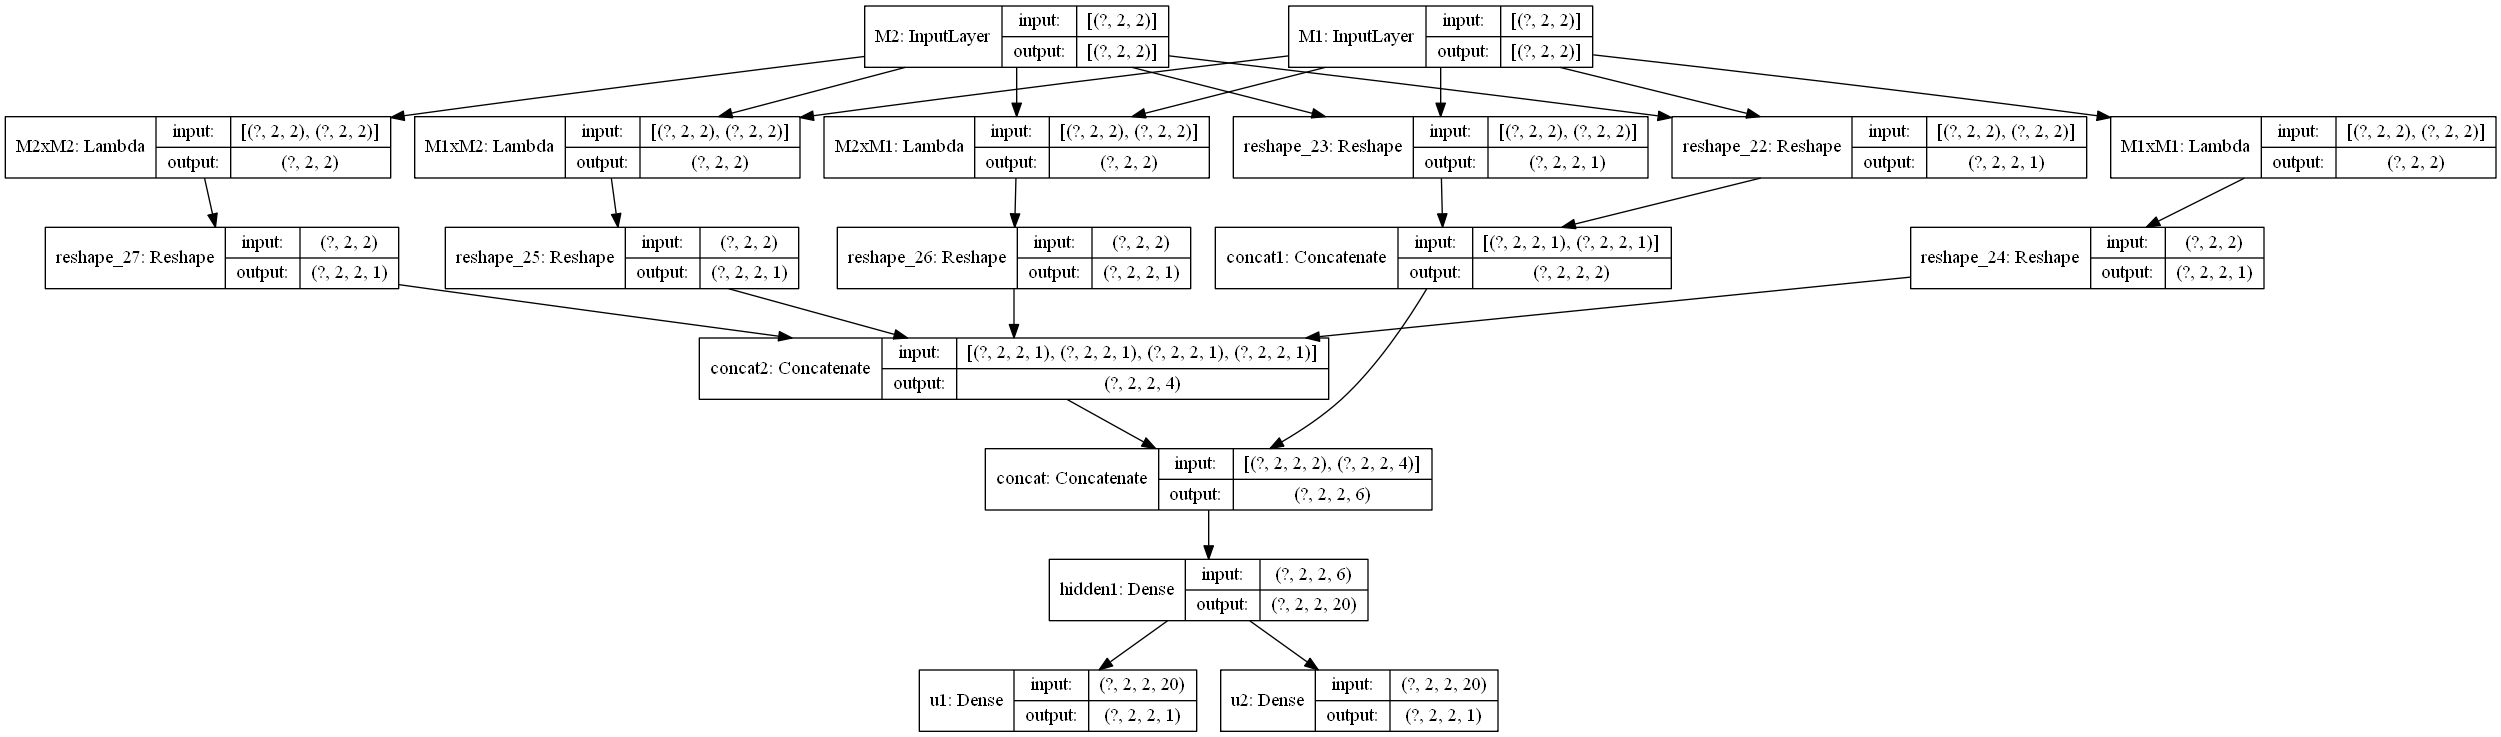

In [45]:
net = OT_network(Cost, 2, (2, 2), 0.01)
net.plot_model

In [46]:
tf.reshape(A, (2,2,1))

<tf.Tensor: id=1086, shape=(2, 2, 1), dtype=float64, numpy=
array([[[0.2],
        [0. ]],

       [[0. ],
        [0.8]]])>

In [47]:
np.array([A]).shape

(1, 2, 2)

In [48]:
potentials, P = net.fit([np.array([A]), np.array([B])], epochs=200)


  0%|                                                                                          | 0/200 [00:00<?, ?it/s]


InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [2,2,2,2] vs. shape[1] = [1,2,2,4] [Op:ConcatV2] name: concat

In [41]:
potentials, P = net.fit(np.array([np.stack([A, B])]), epochs=200)
# print(np.abs(P[0]- np.kron(A, B)))

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]


InvalidArgumentError: Input to reshape is a tensor with 8 values, but the requested shape has 4 [Op:Reshape]

In [188]:
P[0]

<tf.Tensor: id=5117034, shape=(4, 4), dtype=float64, numpy=
array([[0.06234087, 0.06234087, 0.06228762, 0.06228762],
       [0.06234087, 0.06234087, 0.06228762, 0.06228762],
       [0.06228762, 0.06228762, 0.06234087, 0.06234087],
       [0.06228762, 0.06228762, 0.06234087, 0.06234087]])>

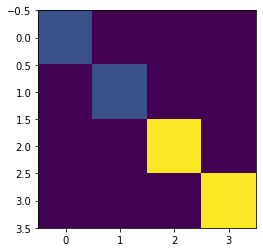

In [189]:
plt.imshow(np.kron(A,B))

In [11]:
A = tf.constant(np.array([np.ones((2,2))]), dtype='int32')
B = tf.constant(np.array([[1,2],[3,4]]), dtype='int32')
prod = np.kron(tf.constant(B), tf.constant(A))
prod

array([[[1, 1, 2, 2],
        [1, 1, 2, 2],
        [3, 3, 4, 4],
        [3, 3, 4, 4]]])

In [8]:
pprod = np.kron(prod, A)

In [9]:
pprod

array([[[1., 1., 1., 1., 2., 2., 2., 2.],
        [1., 1., 1., 1., 2., 2., 2., 2.],
        [1., 1., 1., 1., 2., 2., 2., 2.],
        [1., 1., 1., 1., 2., 2., 2., 2.],
        [3., 3., 3., 3., 4., 4., 4., 4.],
        [3., 3., 3., 3., 4., 4., 4., 4.],
        [3., 3., 3., 3., 4., 4., 4., 4.],
        [3., 3., 3., 3., 4., 4., 4., 4.]]])

In [66]:
C = tf.reshape(B, (2,2,1,1))* tf.reshape(A, (1,1,2,2))

In [67]:
C12 = [tf.concat([C[i,0], C[i,1]], axis=1) for i in range(2)]
tf.concat(C12, axis=0)

<tf.Tensor: id=1988, shape=(4, 4), dtype=float64, numpy=
array([[0.1 , 0.2 , 0.15, 0.3 ],
       [0.2 , 0.4 , 0.3 , 0.6 ],
       [0.15, 0.3 , 0.1 , 0.2 ],
       [0.3 , 0.6 , 0.2 , 0.4 ]])>

In [200]:
C = B[:,:,None, None]*A[0][None,None, :, :]
# C.sum(axis=(0,1))

In [218]:
tf.concat(C[0], axis=1)

<tf.Tensor: id=2592, shape=(2, 2, 2), dtype=float64, numpy=
array([[[1., 1.],
        [1., 1.]],

       [[2., 2.],
        [2., 2.]]])>

In [199]:
[tf.concat([c], axis=1) for c in C]

[<tf.Tensor: id=2558, shape=(2, 2, 2), dtype=float64, numpy=
 array([[[1., 1.],
         [1., 1.]],
 
        [[2., 2.],
         [2., 2.]]])>,
 <tf.Tensor: id=2560, shape=(2, 2, 2), dtype=float64, numpy=
 array([[[3., 3.],
         [3., 3.]],
 
        [[4., 4.],
         [4., 4.]]])>]

In [38]:
[[[[1., 1.],
   [1., 1.]],

  [[2., 2.],
   [2., 2.]]],


 [[[3., 3.],
   [3., 3.]],

  [[4., 4.],
   [4., 4.]]]]

In [43]:
np.reshape(C, (4,4), order='C')

array([[1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3],
       [4, 4, 4, 4]])

In [55]:
((1,2,)+(3,))

(1, 2, 3)

In [63]:
from cvxpy import partial_trace

In [79]:
from scipy.linalg import expm

In [65]:
partial_trace?

In [ ]:
def partial_traces(coupling, mrg_shape, n_mrgnls):
    r"""Calculate the partial traces of the coupling matrix.

    Parameters
    ----------
    coupling : numpy.ndarray
        Coupling matrix
    mrg_shape: tuple
        Size of any marginals, assuming all of them are the same size
    n_mrgnls : int
        Number of marginals

    Returns
    -------
    list of numpy.ndarray
        List of partial traces
    """
    calc_marginals = []
    # looping over the skip index in the partial trace
    for trace_skip_ind in range(n_mrgnls):
        # initialize the calculated marginal with the coupling matrix
        calc_marginal = coupling
        tmp_shape = tuple(mrg_shape[0] for i in range(n_mrgnls))

        # tracing away all other subsystems:
        # $$A_i\approx\text{Tr}_1\text{Tr}_2...\text{Tr}_{i-1}\text{Tr}_{i+1}...\text{Tr}_n P$$
        # where P is the coupling matrix
        for ind in range(n_mrgnls - 1, -1, -1):
            if ind != trace_skip_ind:
                calc_marginal = partial_trace(calc_marginal, tmp_shape, ind).value
                tmp_shape = tmp_shape[:-1]
                # print(tmp_mrg_shape)
        calc_marginals.append(calc_marginal)
    return np.array(calc_marginals)

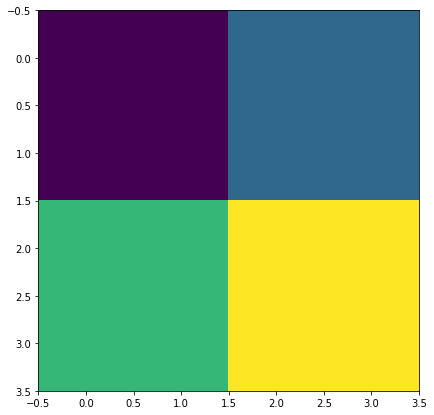

In [97]:
def plotter():
    plt.figure(figsize=(7,7))
    plt.imshow(prod)
    return plt

fig = plotter()
fig.savefig("test.png")

In [101]:
tf.reduce_max(prod)

<tf.Tensor: id=322, shape=(), dtype=float64, numpy=4.0>

In [142]:
 A[0]

array([[1., 1.],
       [1., 1.]])

In [145]:
np.reshape(B, (4,1))

array([[1],
       [2],
       [3],
       [4]])

In [150]:
np.reshape(B, (1, 1, 2, 2))*A[0]

array([[[[1., 2.],
         [3., 4.]]]])

In [181]:
np.stack([tf.concat([bb*A for bb in b], axis=0) for b in B])

array([[[[1., 1.],
         [1., 1.]],

        [[2., 2.],
         [2., 2.]]],


       [[[3., 3.],
         [3., 3.]],

        [[4., 4.],
         [4., 4.]]]])

In [158]:
A[0]

array([[1., 1.],
       [1., 1.]])

In [175]:
np.array([[1], [1], [2], [2]])*A[0]

ValueError: operands could not be broadcast together with shapes (4,1) (2,2) 

In [177]:
np.c_[A,A]

array([[[1., 1., 1., 1.],
        [1., 1., 1., 1.]]])

In [191]:
(tf.reshape(tf.constant(B , dtype='int32'), (2,2,1,1))*tf.reshape(tf.constant(A[0], dtype='int32'), (1,1,2,2))).shape

TensorShape([2, 2, 2, 2])

In [21]:
tf.eye(2)

<tf.Tensor: id=103, shape=(2, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.]], dtype=float32)>

In [10]:
f = lambda x,y: x*y
f(1,2)

2